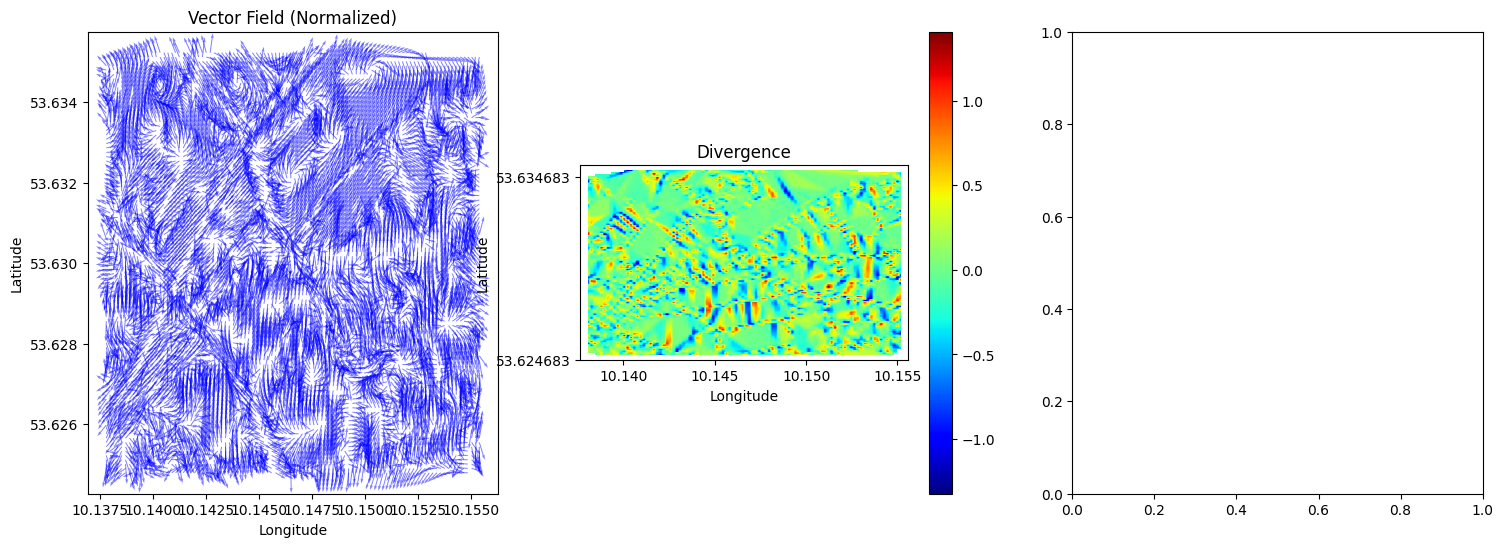

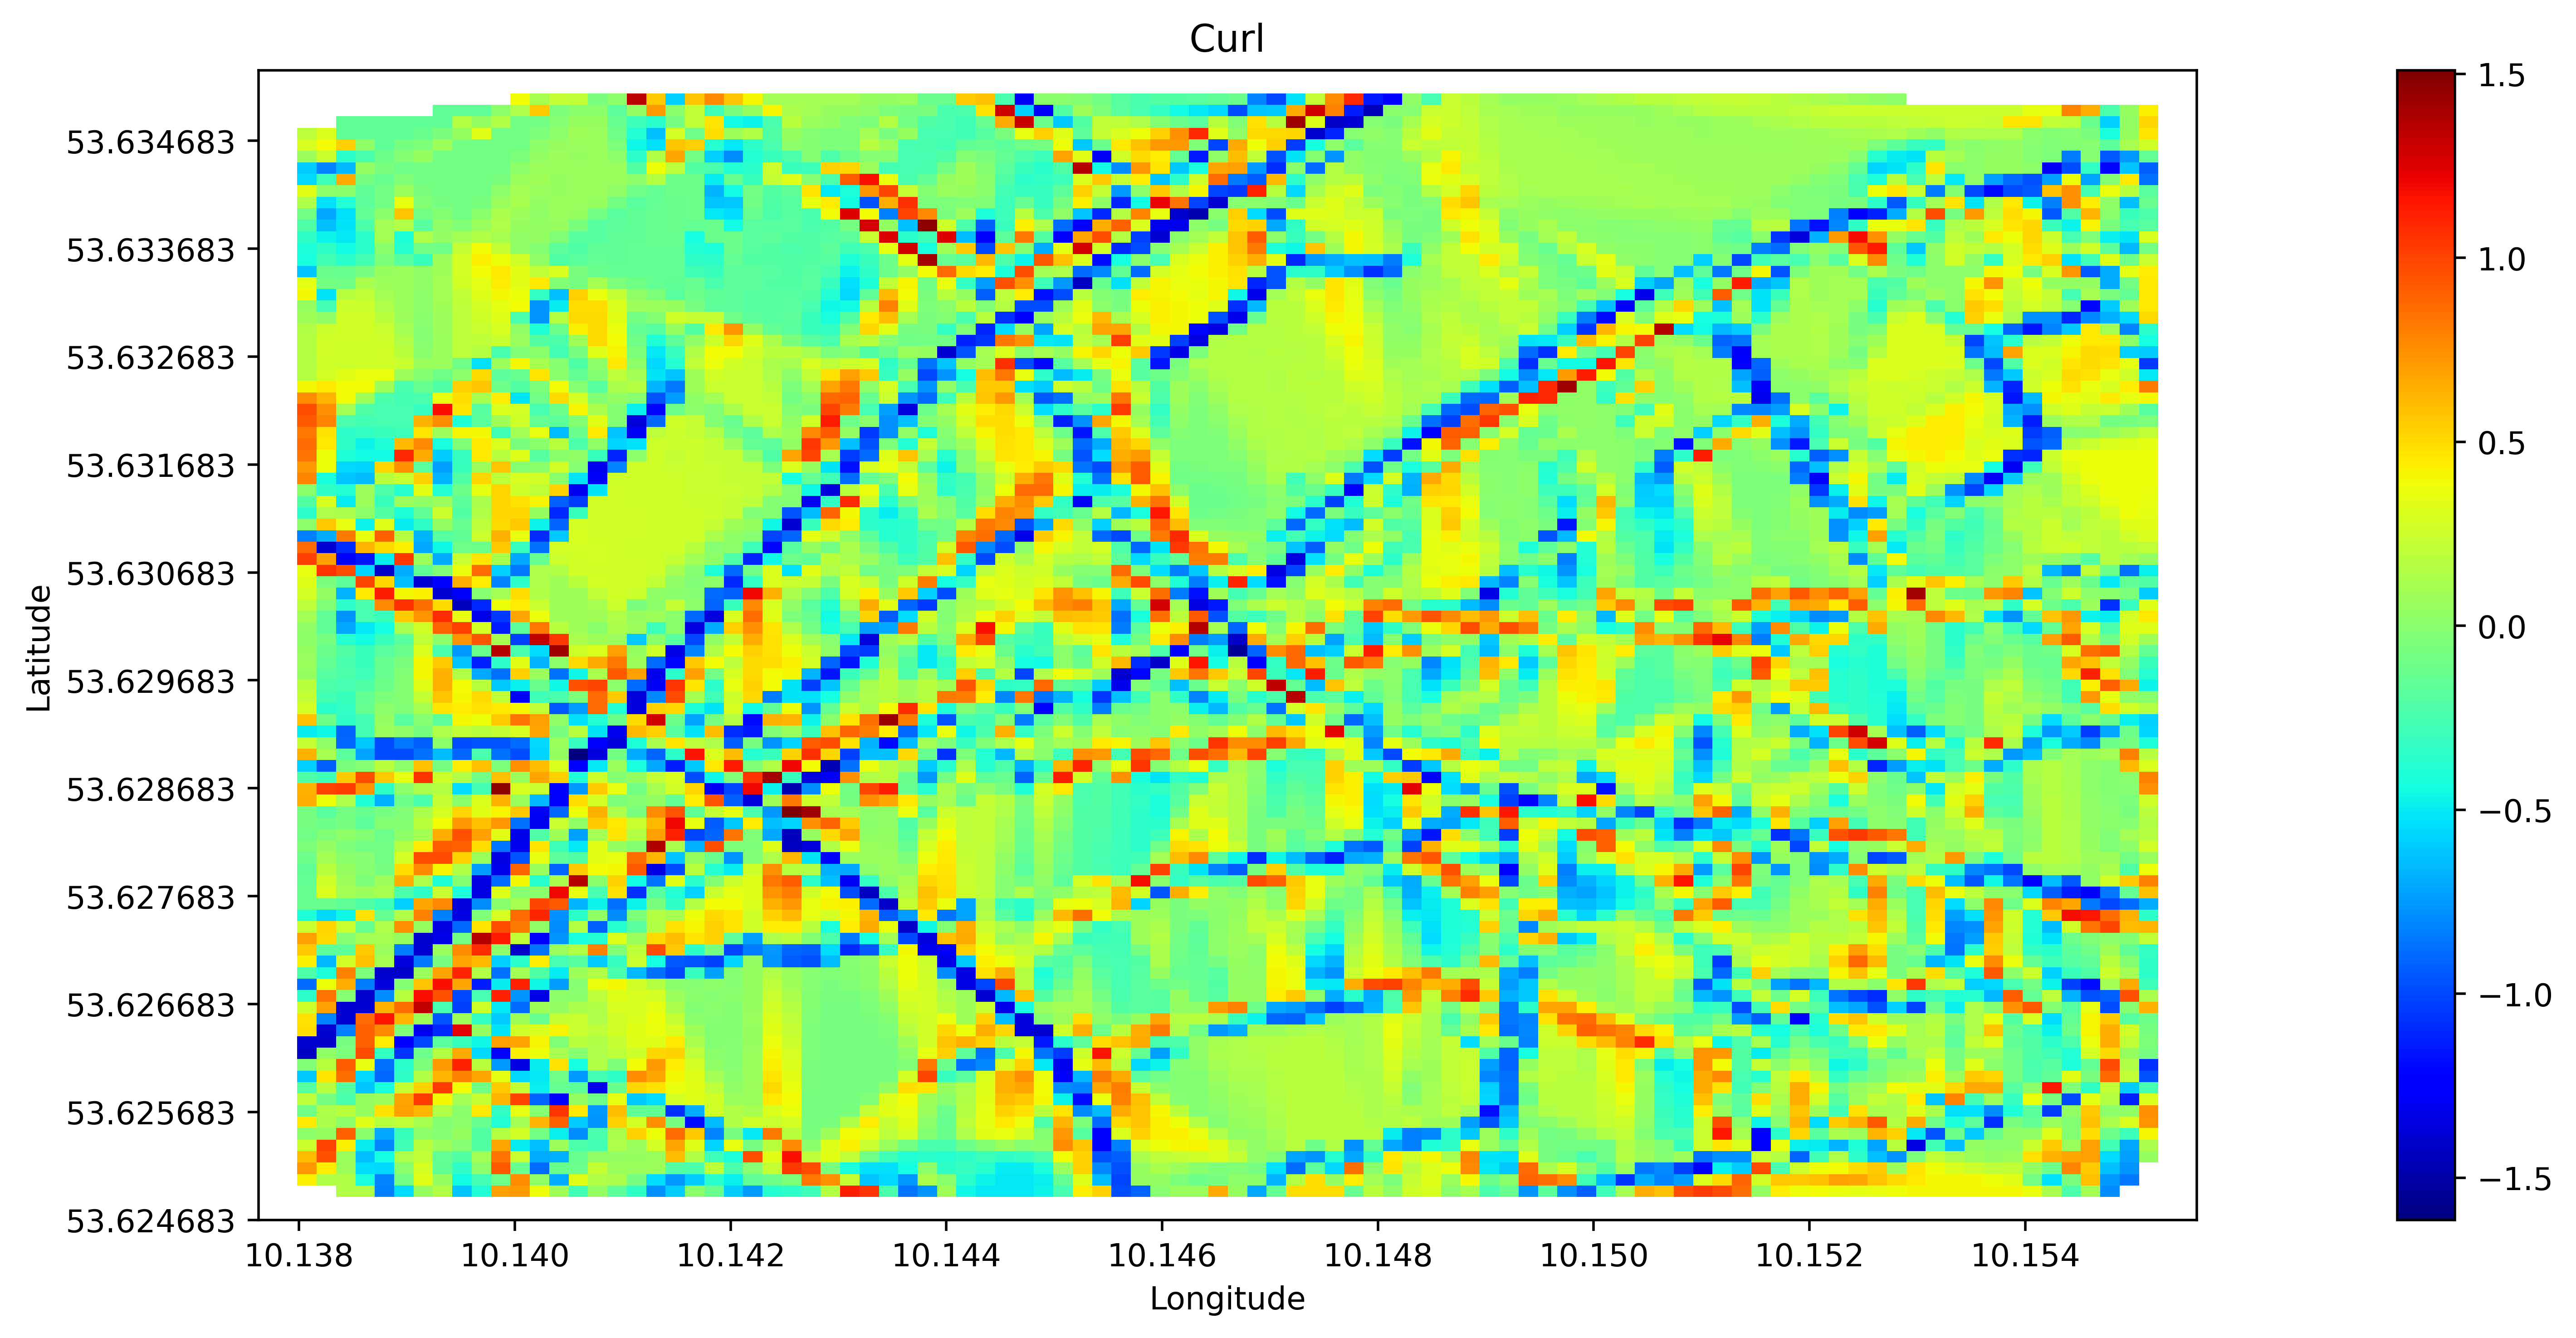

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata

# Load the data
folder_path = 'data/probe_data/1'

data_frames = []
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

# Filter speed data
data = data[(data['speed'] >= 25) & (data['speed'] <= 45)]

# Convert heading from degrees to radians
data['heading_rad'] = np.radians(data['heading'])

# Calculate the vector components
data['vx'] = np.cos(data['heading_rad'])  # Velocity in x-direction
data['vy'] = np.sin(data['heading_rad'])  # Velocity in y-direction

# Increase the grid resolution
grid_lon = np.linspace(data['longitude'].min(), data['longitude'].max(), 100)
grid_lat = np.linspace(data['latitude'].min(), data['latitude'].max(), 100)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Interpolate the vector field onto the finer grid
grid_vx = griddata((data['longitude'], data['latitude']), data['vx'], (grid_lon, grid_lat), method='linear')
grid_vy = griddata((data['longitude'], data['latitude']), data['vy'], (grid_lon, grid_lat), method='linear')

# Calculate curl (2D curl in this case)
curl = np.gradient(grid_vy, axis=0) - np.gradient(grid_vx, axis=1)

# Calculate divergence
divergence = np.gradient(grid_vx, axis=0) + np.gradient(grid_vy, axis=1)

# Calculate curl (2D curl in this case)
curl = np.gradient(grid_vy, axis=0) - np.gradient(grid_vx, axis=1)

# Normalize the vectors to a maximum length
max_length = 0.0005  # Set your desired maximum arrow length

# # Calculate magnitudes
magnitude = np.sqrt(grid_vx**2 + grid_vy**2)

# # Normalize vx and vy based on their magnitudes
normalized_vx = np.where(magnitude != 0, (grid_vx / magnitude) * max_length, 0)
normalized_vy = np.where(magnitude != 0, (grid_vy / magnitude) * max_length, 0)

# Create a mask for valid vector data
valid_mask = ~np.isnan(grid_vx) & ~np.isnan(grid_vy)

# Plotting the vector field, divergence, and curl
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # # Vector field plot using normalized vectors, only where valid data exists
axs[0].quiver(grid_lon[valid_mask], grid_lat[valid_mask], 
               normalized_vx[valid_mask], normalized_vy[valid_mask], 
               angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5)
axs[0].set_title('Vector Field (Normalized)')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# # # Divergence plot
c1 = axs[1].imshow(divergence, extent=(data['longitude'].min(), data['longitude'].max(), data['latitude'].min(), data['latitude'].max()), origin='lower', cmap='jet')
axs[1].set_title('Divergence')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_ylim(data['latitude'].min(), data['latitude'].max())  # Set y-axis limits
axs[1].set_yticks(np.arange(data['latitude'].min(), data['latitude'].max(), step=0.01))  # Adjust step size as needed
fig.colorbar(c1, ax=axs[1])

# # Curl plot
fig, ax = plt.subplots(1, 1, figsize=(18, 6), dpi=500)  # Set dpi to 200 for higher resolution

# Curl plot
c2 = ax.imshow(curl, extent=(data['longitude'].min(), data['longitude'].max(), data['latitude'].min(), data['latitude'].max()), origin='lower', cmap='jet')
ax.set_title('Curl')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_ylim(data['latitude'].min(), data['latitude'].max())  # Set y-axis limits
ax.set_yticks(np.arange(data['latitude'].min(), data['latitude'].max(), step=0.001))  # Adjust step size as needed
fig.colorbar(c2, ax=ax)

# Highlight a specific location
# specific_lon = 10.146605599999
# specific_lat = 	53.630010250000076
# ax.plot(specific_lon, specific_lat, 'ro', markersize=5)  # Adjust markersize for visibility

plt.tight_layout()
plt.show()


In [31]:
max_curl = np.nanmax(curl)  # Use np.nanmax to ignore NaNs if any
print("Maximum Curl Value:", max_curl)

# Step 2: Define a threshold for near-maximum curl (e.g., 90% of max curl)
threshold =  0.9* max_curl  # You can adjust this percentage as needed

# Step 3: Find the indices of points with curl above the threshold
near_max_curl_indices = np.argwhere(curl >= threshold)

# Step 4: Extract corresponding longitude and latitude values
near_max_curl_points = []
for idx in near_max_curl_indices:
    # Get the grid coordinates
    lon_idx, lat_idx = idx[1], idx[0]  # Note: idx gives (y, x) in the 2D array
    lon = grid_lon[lon_idx][lat_idx]
    lat = grid_lat[lon_idx][lat_idx]
    near_max_curl_points.append((lat,lon))

# Convert to DataFrame for easier viewing
near_max_curl_df = pd.DataFrame(near_max_curl_points, columns=['Latitude',''])
near_max_curl_df = pd.DataFrame(near_max_curl_points, columns=['Latitude','Longitude'])

# Step 2: Calculate the mean for Latitude and Longitude
average_lat = near_max_curl_df['Latitude'].mean()
average_lon = near_max_curl_df['Longitude'].mean()

# Step 3: Print the results
print( average_lat, average_lon)


Maximum Curl Value: 1.5100218471219475
53.62829169407273 10.147640025949919
